# Importação e funções

In [52]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

## Classe para fazer as transformações nos datasets

In [53]:
class UmidadeMonthlyTransformer:

    def __init__(self, col_data_idx=0, col_umid_idx=15):
        self.col_data_idx = col_data_idx
        self.col_umid_idx = col_umid_idx

    def load_file(self, file_path: str) -> pd.DataFrame:

        df = pd.read_csv(
            file_path,
            sep=';',
            encoding='latin1',
            skiprows=8,
            decimal=',',
            na_values=['-9999', '-999']
        )
        return df

    def select_cols(self, df: pd.DataFrame) -> pd.DataFrame:

        df = df.iloc[:, [self.col_data_idx, self.col_umid_idx]]
        df.columns = ['data', 'umid']
        return df

    def clean(self, df: pd.DataFrame) -> pd.DataFrame:

        df['data'] = pd.to_datetime(df['data'], errors='coerce')
        df['umid'] = pd.to_numeric(df['umid'], errors='coerce')
        df = df.dropna(subset=['data', 'umid'])
        return df

    def to_monthly(self, df: pd.DataFrame) -> pd.Series:

        df = df.set_index('data')
        df_monthly = df['umid'].resample('MS').mean()
        df_monthly.name = 'umid'
        return df_monthly

    def transform(self, file_path: str) -> pd.Series:

        df = self.load_file(file_path)
        df = self.select_cols(df)
        df = self.clean(df)
        df_monthly = self.to_monthly(df)
        return df_monthly

## Função de treino

In [54]:
def train_sarima(serie, order, seasonal_order):

    modelo = SARIMAX(serie,
                     order=order,
                     seasonal_order=seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
    resultado = modelo.fit(disp=False)

    print(resultado.summary())
    return resultado

## Função de teste

In [55]:
def forecast_sarima(model_results, steps, index=None):
    forecast = model_results.get_forecast(steps=steps)
    pred = forecast.predicted_mean
    conf = forecast.conf_int()
    if index is not None:
        pred.index = index
        conf.index = index
    return pred, conf

## Função para plotar gráfico

In [56]:
def plot_sarima_forecast_tt(train, test, pred, conf, title=None):
    plt.figure(figsize=(10,4))
    plt.plot(train, label="Treino")
    plt.plot(test, label="Teste", color="black")
    plt.plot(pred, label="Previsão", color="red")


    plt.fill_between(conf.index, conf.iloc[:,0], conf.iloc[:,1], color="pink", alpha=0.3, label="Intervalo confiança")

    plt.axvline(x=test.index[0], color="gray", linestyle="--", label="Início teste")

    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Função para calcular erro

In [57]:
def evaluate_forecast(y_true, y_pred):

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    print(f"Erro médio absoluto = {mae:.4f}")
    print(f"Erro quadrático médio = {rmse:.4f}")

## Função para aplicar o transform

In [58]:
transformer = UmidadeMonthlyTransformer()

anos_train = range(2008, 2017)
anos_test  = range(2017, 2020)

series_train = []
series_test  = []

for ano in anos_train:
    arq = f"pvh{ano}.CSV"
    if os.path.exists(arq):
        s = transformer.transform(arq)
        series_train.append(s)
    else:
        print(f"Arquivo nao encontrado: {arq}")

for ano in anos_test:
    arq = f"pvh{ano}.CSV"
    if os.path.exists(arq):
        s = transformer.transform(arq)
        series_test.append(s)
    else:
        print(f"Arquivo nao encontrado: {arq}")

In [64]:
series_train

[data
 2008-01-01    85.829468
 2008-02-01    86.325109
 2008-03-01    86.487062
 2008-04-01    85.200594
 2008-05-01    83.339189
 2008-06-01    81.589235
 2008-07-01    69.933060
 2008-08-01    67.942657
 2008-09-01    72.623955
 2008-10-01    76.033784
 2008-11-01    83.980447
 2008-12-01    86.202156
 Freq: MS, Name: umid, dtype: float64,
 data
 2009-01-01    86.051421
 2009-02-01    87.016794
 2009-03-01    86.326870
 2009-04-01    85.767606
 2009-05-01    85.568336
 2009-06-01    84.215493
 2009-07-01    78.729767
 2009-08-01    74.760544
 2009-09-01    75.412831
 2009-10-01    77.559229
 2009-11-01    83.022222
 2009-12-01    86.283602
 Freq: MS, Name: umid, dtype: float64,
 data
 2010-01-01    85.914980
 2010-02-01    84.866071
 2010-03-01    84.623149
 2010-04-01    81.312500
 2010-05-01    80.384409
 2010-06-01    75.956885
 2010-07-01    69.459677
 2010-08-01    55.626998
 2010-09-01    51.181818
 2010-10-01    60.035294
 2010-11-01    67.140625
 2010-12-01    82.775312
 Fre

## Concatena em um dataframe

In [59]:
train = pd.concat(series_train).sort_index()
test  = pd.concat(series_test).sort_index()

In [60]:
train

,umid
data,
2008-01-01,85.829468
2008-02-01,86.325109
2008-03-01,86.487062
2008-04-01,85.200594
2008-05-01,83.339189
2008-06-01,81.589235
2008-07-01,69.933060
2008-08-01,67.942657
2008-09-01,72.623955


## Preenche valores faltantes com interpolação temporal

In [61]:
train = train.asfreq('MS')
train = train.interpolate(method='time')

In [13]:
train = train.to_frame(name='umid')
test  = test.to_frame(name='umid')

# Treino modelo 1 (1, 0, 2), (1, 1, 1, 12)

In [41]:
model = train_sarima(train['umid'], (1, 0, 2), (1, 1, 1, 12))

n_steps = len(test)

pred1, conf1 = forecast_sarima(model, n_steps, test.index)

                                      SARIMAX Results                                       
Dep. Variable:                                 umid   No. Observations:                  108
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -220.943
Date:                              Thu, 04 Dec 2025   AIC                            453.885
Time:                                      01:53:48   BIC                            468.252
Sample:                                  01-01-2008   HQIC                           459.649
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7853      0.110      7.150      0.000       0.570       1.001
ma.L1          0.06

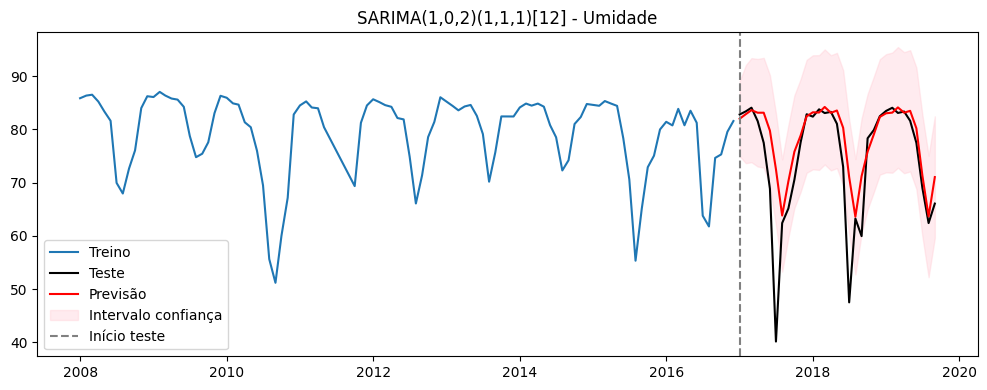

In [31]:
plot_sarima_forecast_tt(train['umid'], test['umid'], pred1, conf1, title="SARIMA(1,0,2)(1,1,1)[12] - Umidade")

In [46]:
evaluate_forecast(test['umid'], pred1)

Erro médio absoluto = 4.0194
Erro quadrático médio = 7.8860


# Treino modelo 2 (1, 1, 1), (1, 1, 1, 12)

In [42]:
model2 = train_sarima(train['umid'], (1, 1, 1), (1, 1, 1, 12))

pred2, conf2 = forecast_sarima(model2, n_steps, test.index)

                                     SARIMAX Results                                      
Dep. Variable:                               umid   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -224.195
Date:                            Thu, 04 Dec 2025   AIC                            458.389
Time:                                    01:54:11   BIC                            470.362
Sample:                                01-01-2008   HQIC                           463.193
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7201      0.069     10.460      0.000       0.585       0.855
ma.L1         -1.0000    171.823   

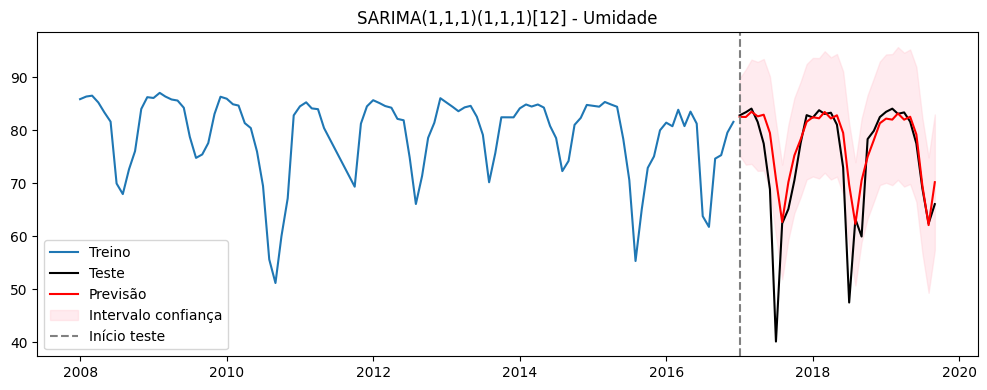

In [49]:
plot_sarima_forecast_tt(train['umid'], test['umid'], pred2, conf2, title="SARIMA(1,1,1)(1,1,1)[12] - Umidade")

In [47]:
evaluate_forecast(test['umid'], pred2)

Erro médio absoluto = 3.7934
Erro quadrático médio = 7.4548


# Treino modelo 3 (1, 1, 2), (1, 1, 1, 12)

In [48]:
model3 = train_sarima(train['umid'], (1, 1, 2), (1, 1, 1, 12))

pred3, conf3 = forecast_sarima(model3, n_steps, test.index)

                                      SARIMAX Results                                       
Dep. Variable:                                 umid   No. Observations:                  108
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -220.992
Date:                              Thu, 04 Dec 2025   AIC                            453.983
Time:                                      01:57:45   BIC                            468.275
Sample:                                  01-01-2008   HQIC                           459.713
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4745      0.226      2.099      0.036       0.031       0.918
ma.L1         -0.57

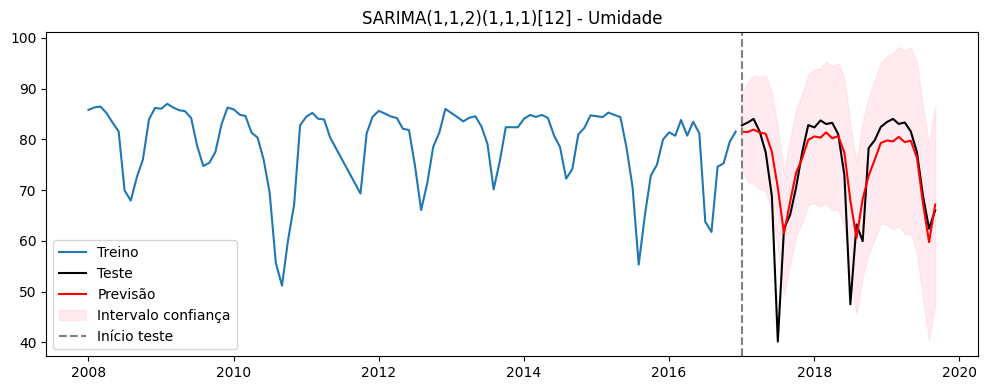

In [50]:
plot_sarima_forecast_tt(train['umid'], test['umid'], pred3, conf3, title="SARIMA(1,1,2)(1,1,1)[12] - Umidade")

In [51]:
evaluate_forecast(test['umid'], pred3)

Erro médio absoluto = 4.2398
Erro quadrático médio = 7.2000
